In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm

from xgcm import Grid

In [26]:
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-shelf/intxpa-testing'
def open_files(label):
    base = basee 
    prog = xr.open_dataset(base + '/prog-'+label+'.nc')
    return prog
def open_IC(label):
    base = basee 
    IC = xr.open_dataset(base + '/MOM_IC-'+label+'.nc')
    return IC
def open_visc(label):
    base = basee 
    IC = xr.open_dataset(base + '/visc-'+label+'.nc')
    return IC
def open_mom(label):
    base = basee 
    IC = xr.open_dataset(base + '/mom-'+label+'.nc')
    return IC

def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog = open_files(label)
    ocean_static = xr.open_dataset('ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    IC = open_IC(label)
    depth = grid.interp(prog.e,"x")
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
        dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    #plt.colorbar(cax, ax = ax, label = varname)
    plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


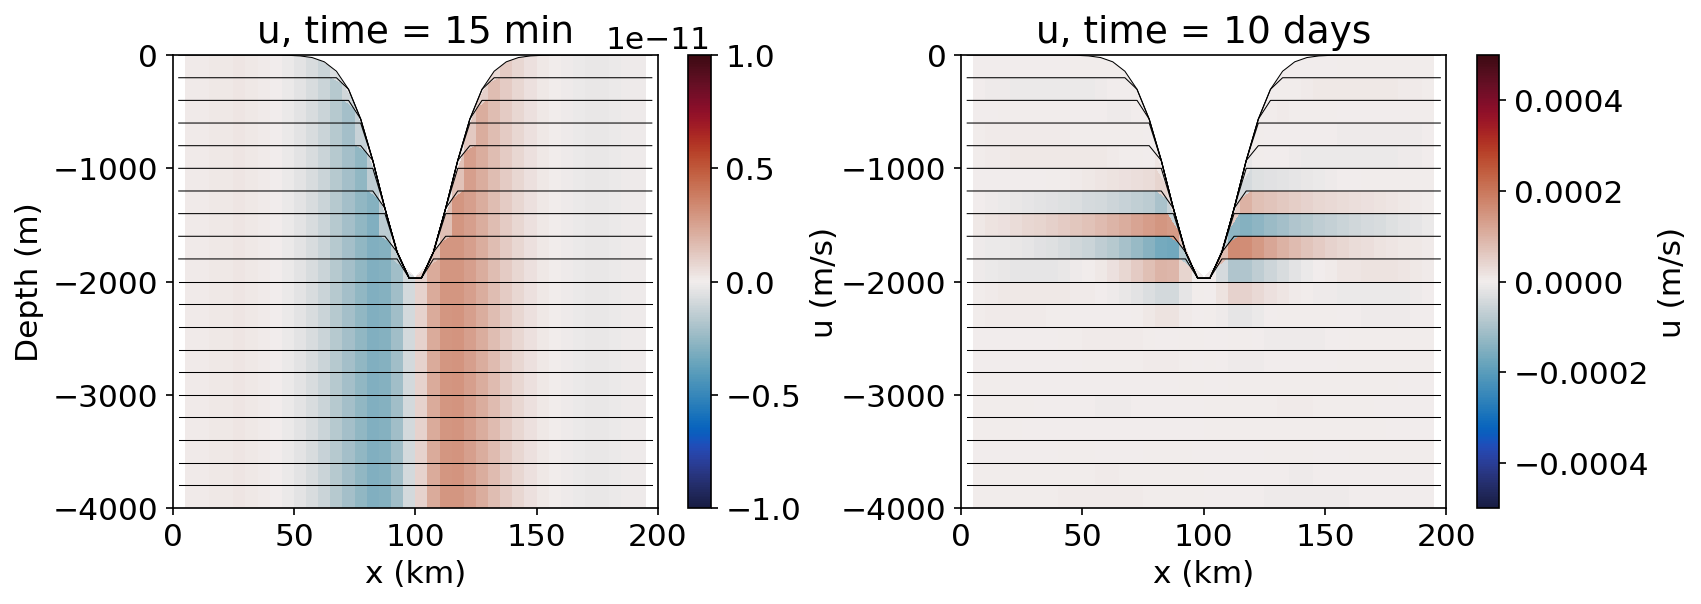

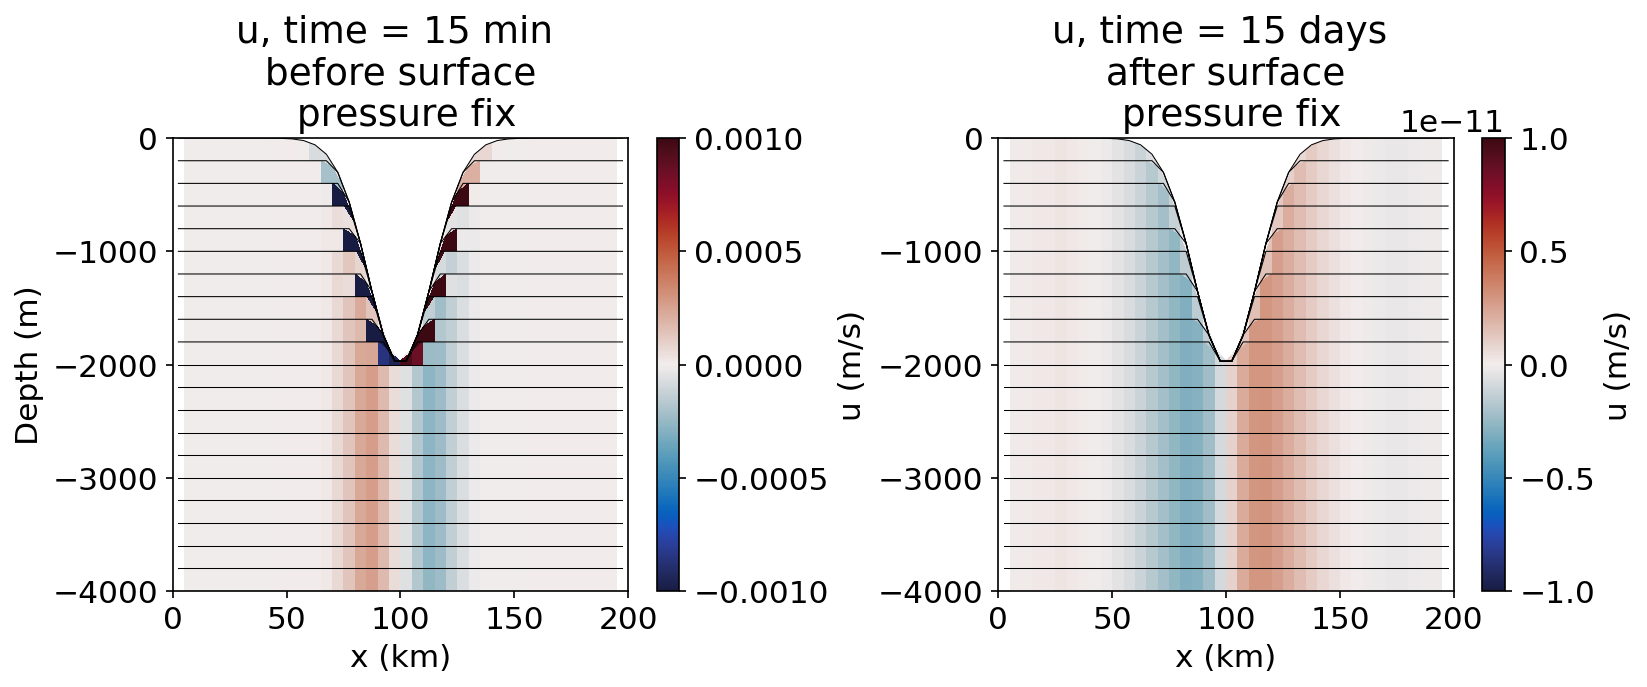

In [34]:
plt.rcParams.update({'font.size': 15})


label = 'zstar-minthick1e-12-intxpa'

fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 150)
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 0#24*5-1
ymax = 4000
plot(axes[0],x,time,0,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)
plot(axes[1],x,-1,0,prog.u,"uo",-5e-4,5e-4,cm.cm.balance,ymax)

axes[1].set_ylabel('')
axes[0].set_title('u, time = 15 min')
axes[1].set_title('u, time = 10 days')
fig.subplots_adjust(wspace = 0.3)
plt.show()

label = 'zstar-minthick1e-12-oldintxpa'

fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 150)
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 0#24*5-1
ymax = 4000
plot(axes[0],x,time,0,prog.u,"uo",-1e-3,1e-3,cm.cm.balance,ymax)

label = 'zstar-minthick1e-12-intxpa'
prog = open_files(label)
IC = open_IC(label)

plot(axes[1],x,time,0,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)

axes[1].set_ylabel('')
axes[0].set_title('u, time = 15 min \n before surface \n pressure fix')
axes[1].set_title('u, time = 15 days \n after surface \n pressure fix')
fig.subplots_adjust(wspace = 0.45)


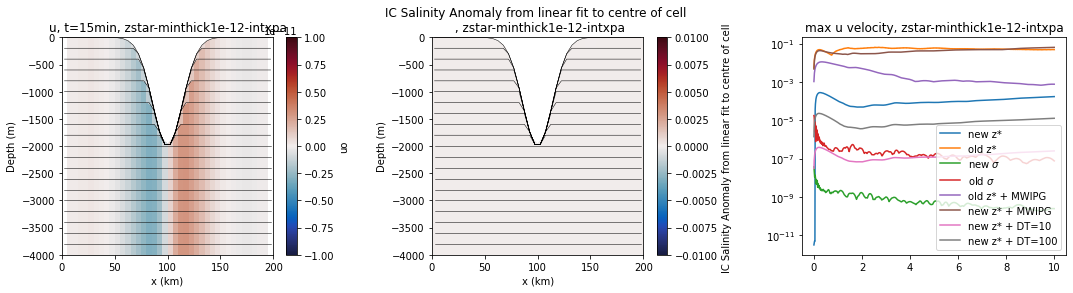

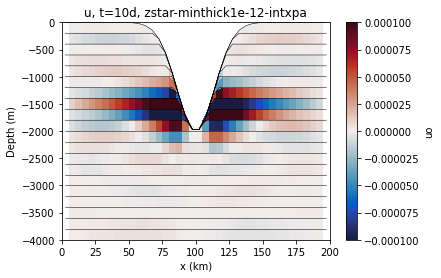

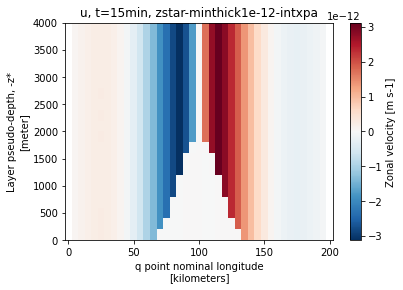

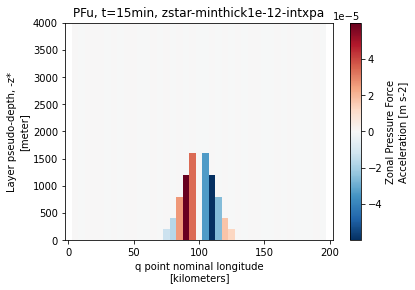

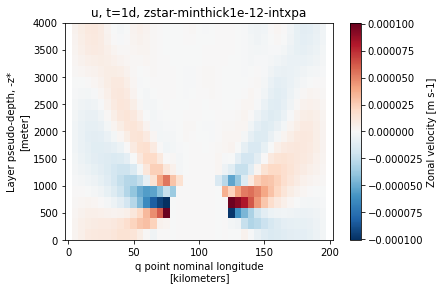

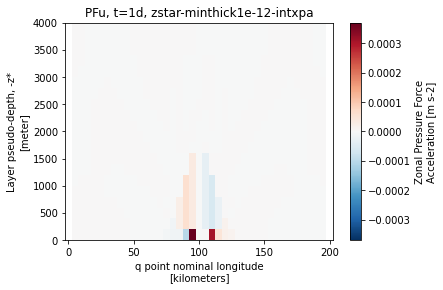

Text(0.5, 1.0, 'max u velocity, zstar-minthick1e-12-intxpa-dt10')

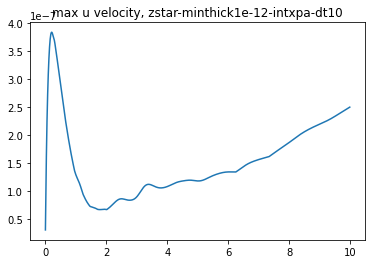

In [38]:
label = 'zstar-minthick1e-12-intxpa'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 0#24*5-1
ymax = 4000
plot(axes[0],x,time,0,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)
axes[0].set_title('u, t=15min, '+label)

prog = open_files(label)
IC = open_IC(label)

#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"IC Salinity Anomaly from linear fit to centre of cell \n",-1e-2,1e-2,cm.cm.balance,ymax)

axes[2].plot(np.arange(len(prog.Time))/24/4, prog.u.max(['xq','yh','zl']).values, label = 'new z*')
axes[2].set_title('max u velocity, '+label)

prog2 = open_files('zstar-minthick1e-12-oldintxpa')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'old z*')
prog2 = open_files('sigma-minthick1e-12-intxpa-hack')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'new $\sigma$')
prog2 = open_files('sigma-minthick1e-12-oldintxpa-hack')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'old $\sigma$')
prog2 = open_files('zstar-minthick1e-12-oldintxpa-mwipg')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'old z* + MWIPG')
prog2 = open_files('zstar-minthick1e-12-intxpa-mwipg')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'new z* + MWIPG')
prog2 = open_files('zstar-minthick1e-12-intxpa-dt10')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'new z* + DT=10')
prog2 = open_files('zstar-minthick1e-12-intxpa-dt100')
axes[2].plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'new z* + DT=100')

axes[2].legend()
axes[2].set_yscale('log')
fig.subplots_adjust(wspace = 0.4)
plt.show()

label = 'zstar-minthick1e-12-intxpa'

fig, axes = plt.subplots()
prog = open_files(label)
IC = open_IC(label)
mom = open_mom(label)
x = 0
time = -1#24*5-1
ymax = 4000
plot(axes,x,time,0,prog.u,"uo",-0.0001,0.0001,cm.cm.balance,ymax)
axes.set_title('u, t=10d, '+label)
plt.show()
fig, axes = plt.subplots()
prog.u.isel(yh = 0, Time = 0).plot(ax = axes)
axes.set_title('u, t=15min, '+label)
plt.show()
fig, axes = plt.subplots()
mom.PFu.isel(yh = 0, Time = 0).plot(ax = axes)
axes.set_title('PFu, t=15min, '+label)
plt.show()
fig, axes = plt.subplots()
prog.u.isel(yh = 0, Time = 24*4).plot(ax = axes)
axes.set_title('u, t=1d, '+label)
plt.show()
fig, axes = plt.subplots()
mom.PFu.isel(yh = 0, Time = 24*4).plot(ax = axes)
axes.set_title('PFu, t=1d, '+label)
plt.show()

label = 'zstar-minthick1e-12-intxpa-dt10'
prog = open_files(label)

plt.plot(np.arange(len(prog.Time))/24/4, prog.u.max(['xq','yh','zl']).values, label = 'new z*')
plt.title('max u velocity, '+label)


Text(0.5, 1.0, 'Icemount - ALE coordinates')

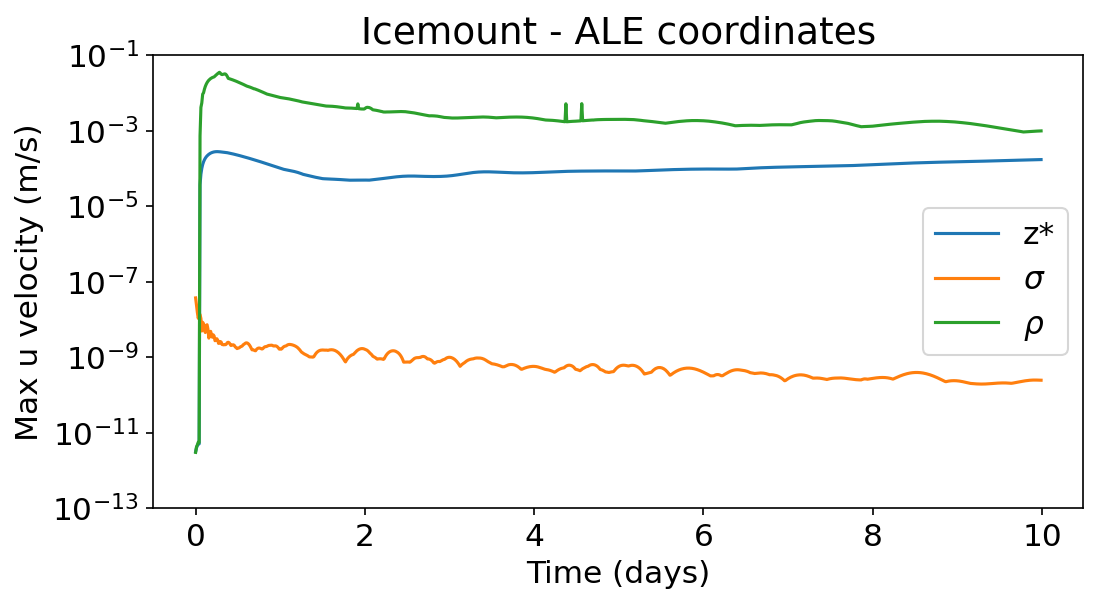

In [47]:

fig, axes = plt.subplots(ncols = 1, figsize = (8,4),dpi = 150)
label = 'zstar-minthick1e-12-intxpa'
prog = open_files(label)
axes.plot(np.arange(len(prog.Time))/24/4, prog.u.max(['xq','yh','zl']).values, label = 'z*')
axes.set_title('max u velocity, '+label)

prog2 = open_files('sigma-minthick1e-12-intxpa-hack')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = r'$\sigma$')
prog2 = open_files('rho')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = r'$\rho$')

axes.legend()
axes.set_yscale('log')
axes.set_ylim(1e-13,1e-1)
axes.set_ylabel('Max u velocity (m/s)')
axes.set_xlabel('Time (days)')
axes.set_title('Icemount - ALE coordinates')


Text(0.5, 1.0, 'Icemount - ALE coordinates')

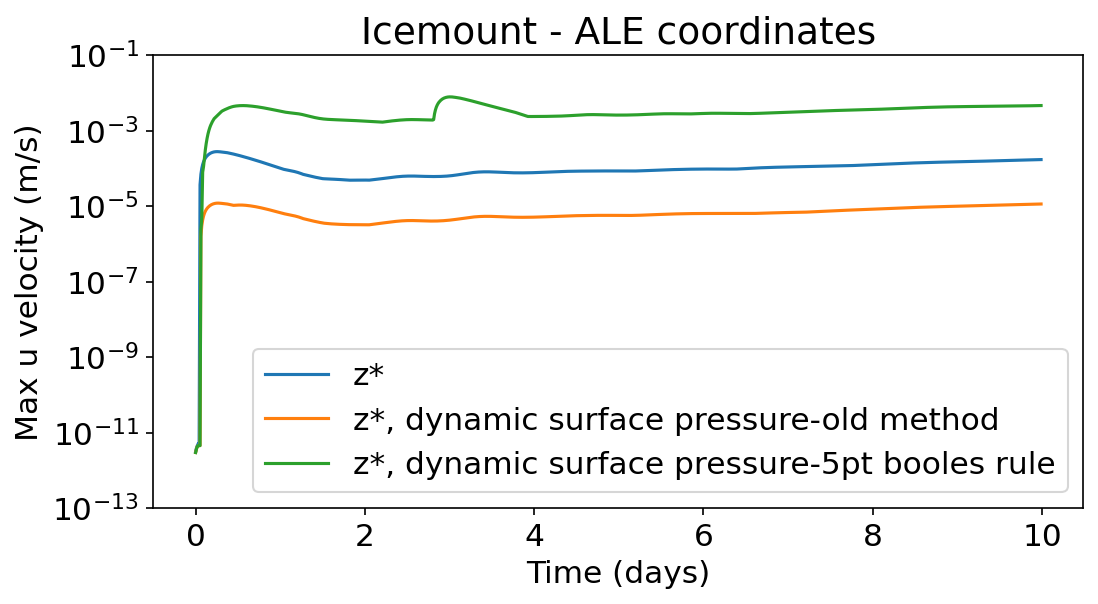

In [50]:

fig, axes = plt.subplots(ncols = 1, figsize = (8,4),dpi = 150)
label = 'zstar-minthick1e-12-intxpa'
prog = open_files(label)
axes.plot(np.arange(len(prog.Time))/24/4, prog.u.max(['xq','yh','zl']).values, label = 'z*')
axes.set_title('max u velocity, '+label)

prog2 = open_files('zstar-minthick1e-12-intxpa-dynsurfp')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'z*, dynamic surface pressure-old method')
prog2 = open_files('zstar-minthick1e-12-intxpa-dynsurfp-5pt')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = 'z*, dynamic surface pressure-5pt booles rule')

axes.legend()
axes.set_yscale('log')
axes.set_ylim(1e-13,1e-1)
axes.set_ylabel('Max u velocity (m/s)')
axes.set_xlabel('Time (days)')
axes.set_title('Icemount - ALE coordinates')


Text(0.5, 1.0, 'Seamount - ALE coordinates (no MWIPG)')

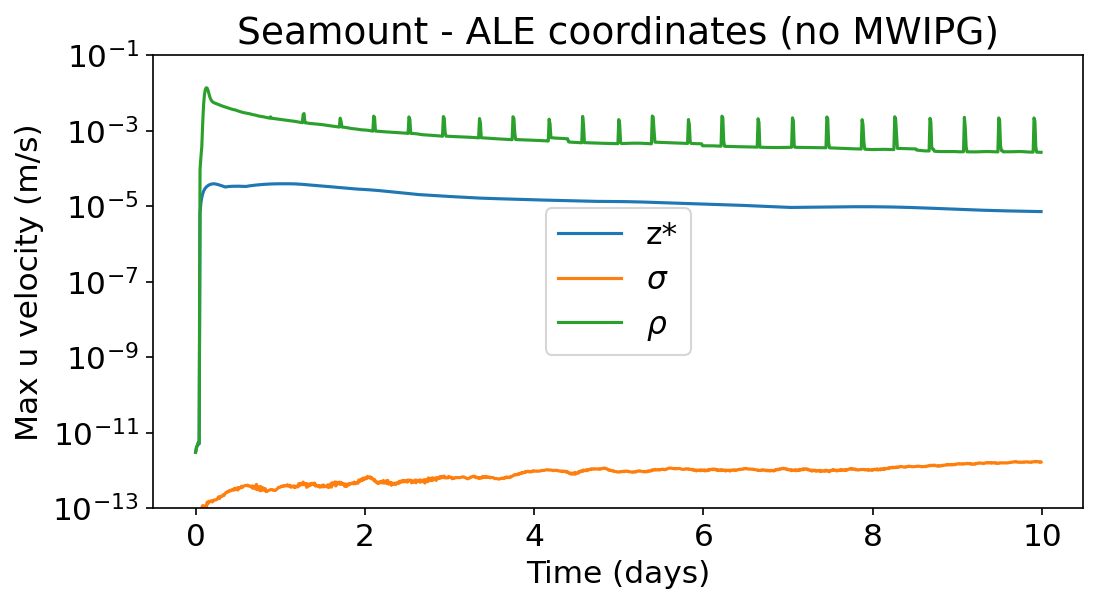

In [46]:

fig, axes = plt.subplots(ncols = 1, figsize = (8,4),dpi = 150)
label = 'toposeamount-zstar-minthick1e-12-intxpa'
prog = open_files(label)
axes.plot(np.arange(len(prog.Time))/24/4, prog.u.max(['xq','yh','zl']).values, label = 'z*')
axes.set_title('max u velocity, '+label)

prog2 = open_files('toposeamount-sigma')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = r'$\sigma$')
prog2 = open_files('toposeamount-rho')
axes.plot(np.arange(len(prog.Time))/24/4, prog2.u.max(['xq','yh','zl']).values, label = r'$\rho$')

axes.legend()
axes.set_yscale('log')
axes.set_ylim(1e-13,1e-1)
axes.set_ylabel('Max u velocity (m/s)')
axes.set_xlabel('Time (days)')
axes.set_title('Seamount - ALE coordinates (no MWIPG)')


Text(0.5, 1.0, 'max u velocity, sigma-minthick1e-12-intxpa')

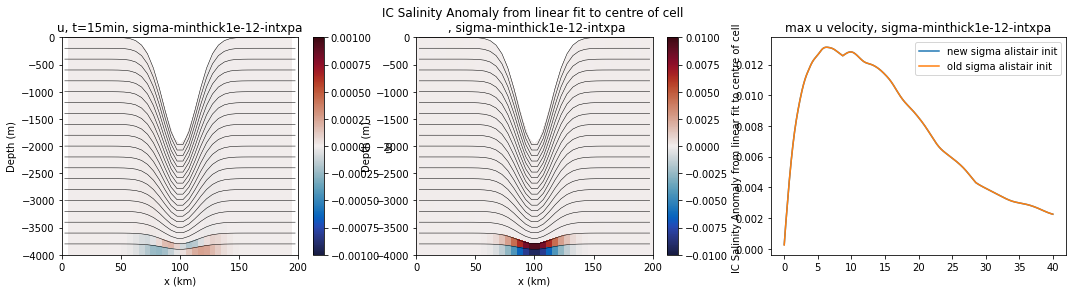

In [31]:
label = 'sigma-minthick1e-12-intxpa'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 0#24*5-1
ymax = 4000
plot(axes[0],x,time,0,prog.u,"uo",-1e-3,1e-3,cm.cm.balance,ymax)
axes[0].set_title('u, t=15min, '+label)

prog = open_files(label)
IC = open_IC(label)

#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"IC Salinity Anomaly from linear fit to centre of cell \n",-1e-2,1e-2,cm.cm.balance,ymax)

axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'new sigma alistair init')
prog = open_files('sigma-minthick1e-12-oldintxpa')
axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'old sigma alistair init')
axes[2].legend()
axes[2].set_title('max u velocity, '+label)


Text(0.5, 1.0, 'max u velocity, \ntoposeamount-zstar-minthick1e-12-intxpa-mwipg')

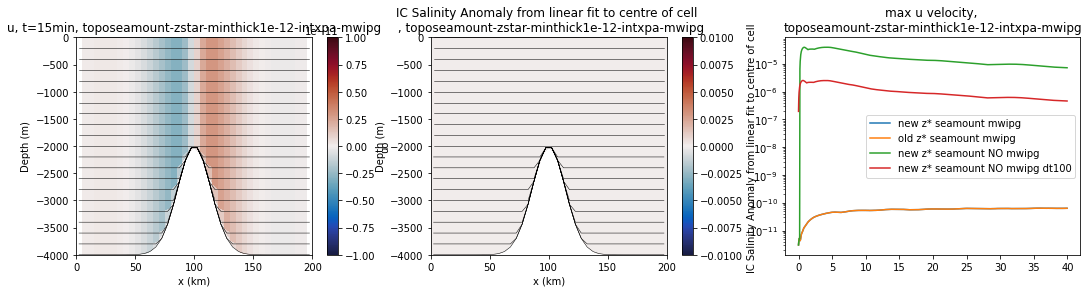

In [39]:
label = 'toposeamount-zstar-minthick1e-12-intxpa-mwipg'

fig, axes = plt.subplots(ncols = 3, figsize = (18,4))
prog = open_files(label)
IC = open_IC(label)
x = 0
time = 0#24*5-1
ymax = 4000
plot(axes[0],x,time,0,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)
axes[0].set_title('u, t=15min, '+label)

prog = open_files(label)
IC = open_IC(label)

#plot(axes[1],x,time,0,prog.salt,"salt",33.7,34.6,cm.cm.haline,ymax)
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"IC Salinity Anomaly from linear fit to centre of cell \n",-1e-2,1e-2,cm.cm.balance,ymax)

axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'new z* seamount mwipg')
prog = open_files('toposeamount-zstar-minthick1e-12-oldintxpa-mwipg')
axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'old z* seamount mwipg')
prog = open_files('toposeamount-zstar-minthick1e-12-intxpa')
axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'new z* seamount NO mwipg')
prog = open_files('toposeamount-zstar-minthick1e-12-intxpa-dt100')
axes[2].plot(np.arange(len(prog.Time))/24, prog.u.max(['xq','yh','zl']).values, label = 'new z* seamount NO mwipg dt100')
axes[2].set_yscale('log')
axes[2].legend()
axes[2].set_title('max u velocity, \n'+label)


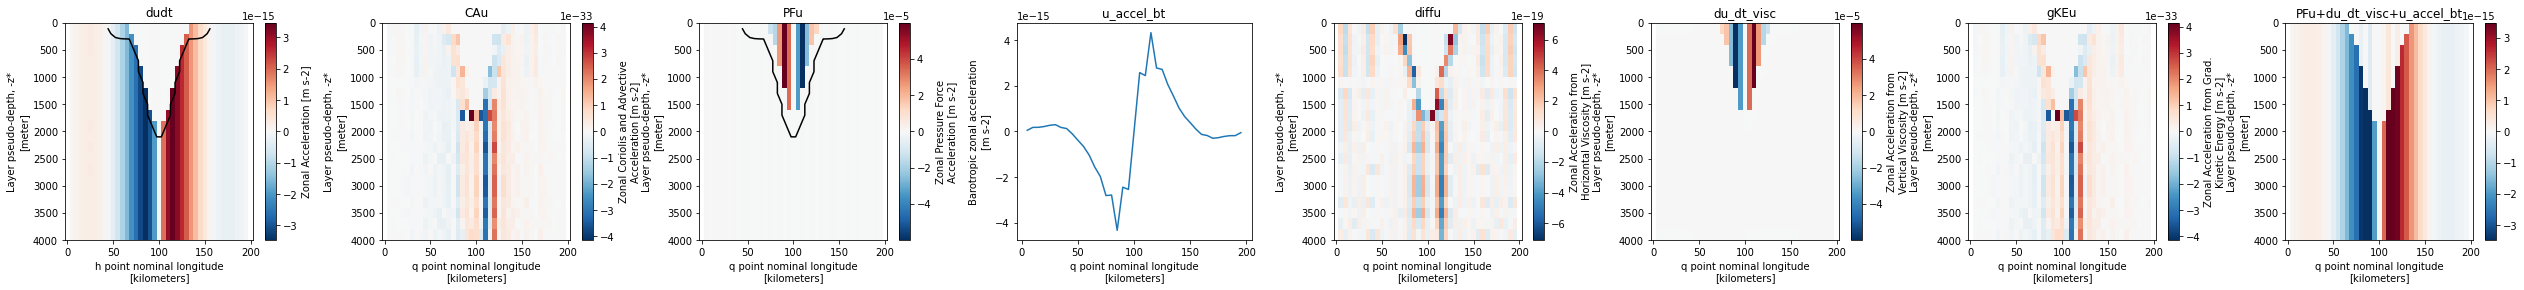

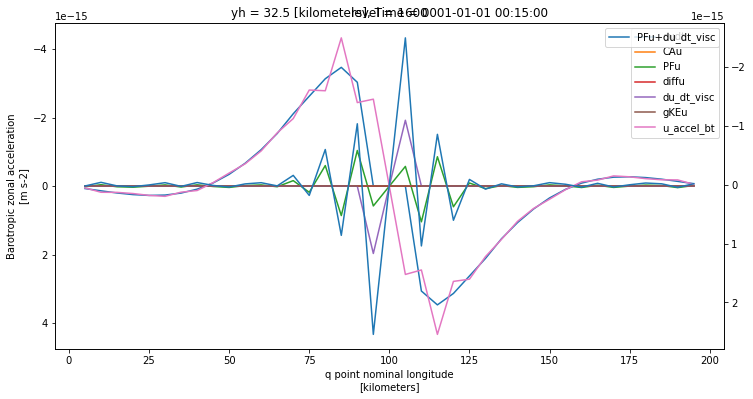

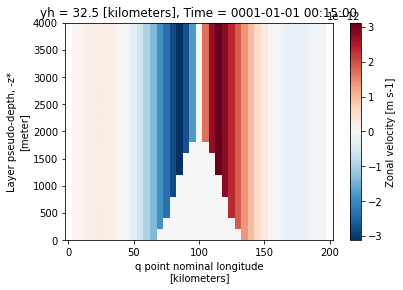

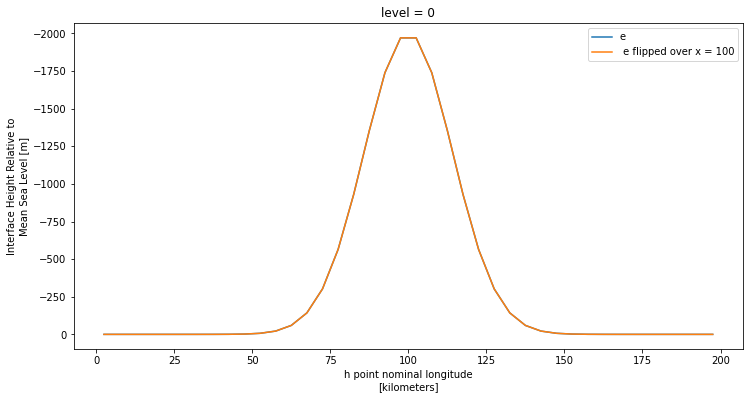

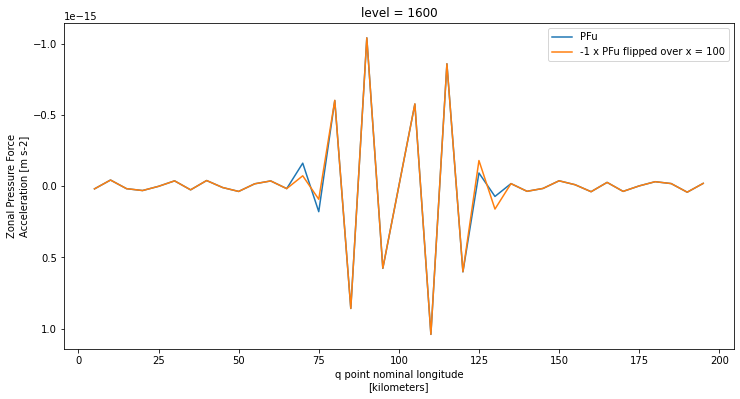

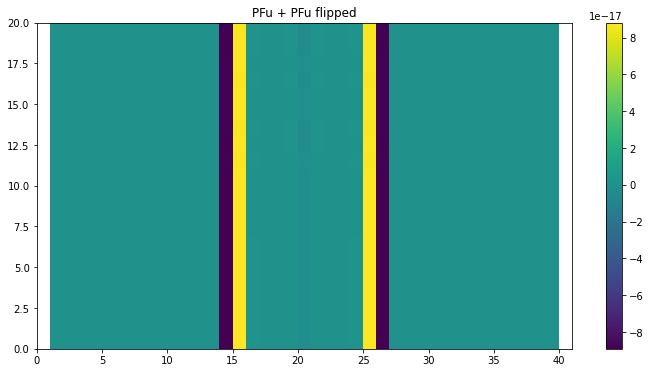

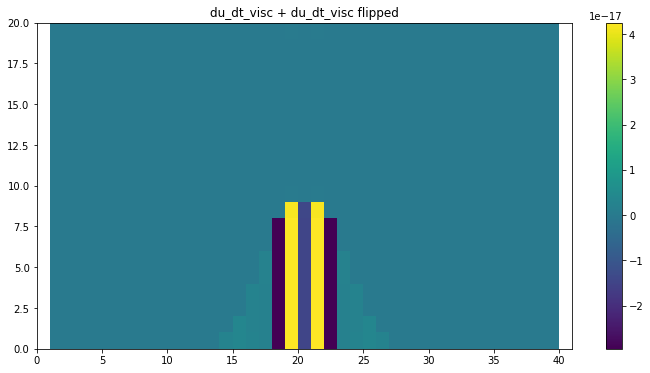

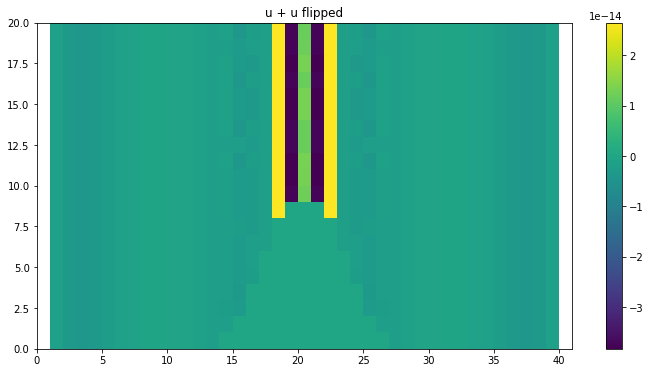

In [86]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 0
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))
plt.show()
prog.u.isel(yh = 0, Time = time).plot()
plt.show()
####
fig, ax = plt.subplots(figsize = (12,6))
depth = 0
for term in ['e']:
    prog[term].isel(Time = time, yh = y).sel(zi = depth, method = 'nearest').plot(yincrease = False, label = term)
plt.plot(200-prog.xh.values,prog[term].isel(Time = time, yh = y).sel(zi = depth, method = 'nearest').values, label = ' e flipped over x = 100')
plt.legend()
plt.title('level = '+str(depth))
plt.show()


depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['PFu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
plt.plot(200-mom.PFu.xq.values,-1*mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').values, label = '-1 x PFu flipped over x = 100')
plt.legend()
plt.title('level = '+str(depth))
plt.show()


depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
term = 'PFu'
plt.pcolormesh(mom[term].isel(Time = time, yh = y)+np.flip(mom[term].isel(Time = time, yh = y).values,axis = 1), label = '-1 x PFu flipped over x = 100')
plt.colorbar()
plt.title('PFu + PFu flipped')
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
term = 'du_dt_visc'
plt.pcolormesh(mom[term].isel(Time = time, yh = y)+np.flip(mom[term].isel(Time = time, yh = y).values,axis = 1), label = '-1 x PFu flipped over x = 100')
plt.colorbar()
plt.title('du_dt_visc + du_dt_visc flipped')
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
term = 'u'
plt.pcolormesh(prog[term].isel(Time = time, yh = y)+np.flip(prog[term].isel(Time = time, yh = y).values,axis = 1), label = '-1 x PFu flipped over x = 100')
plt.colorbar()
plt.title('u + u flipped')
plt.show()


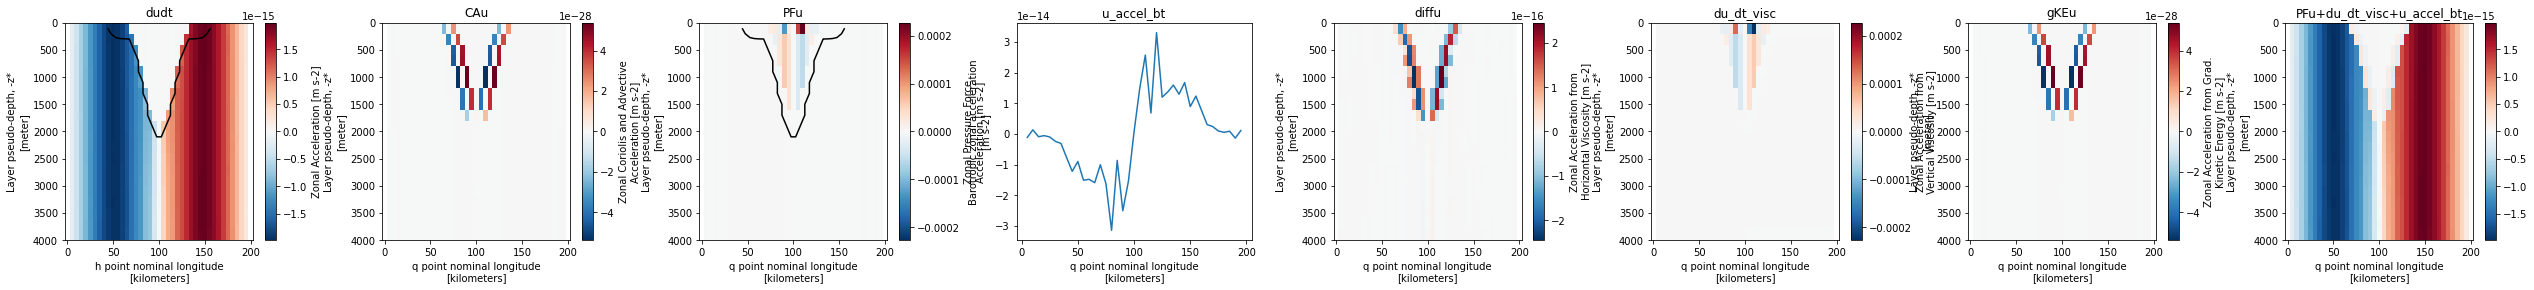

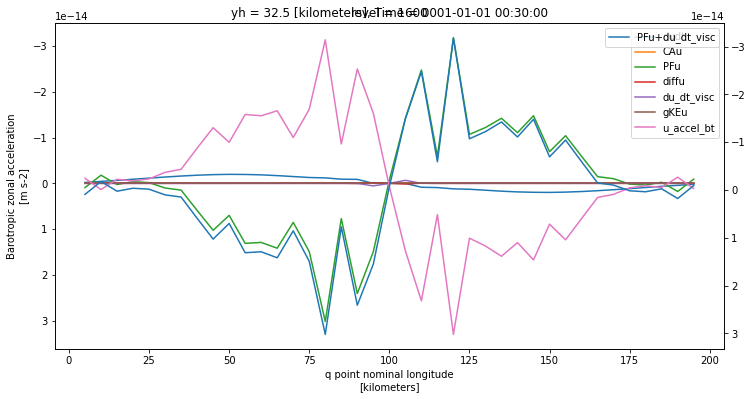

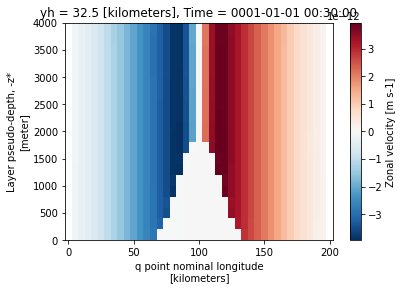

In [55]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 1
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))
plt.show()
prog.u.isel(yh = 0, Time = time).plot()

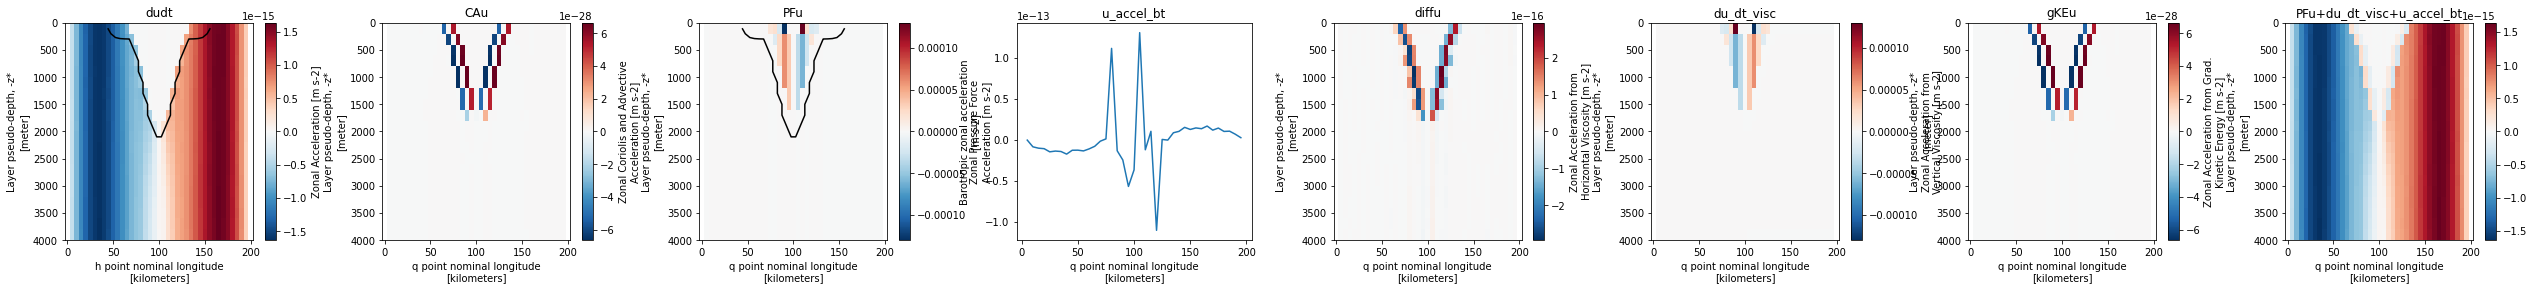

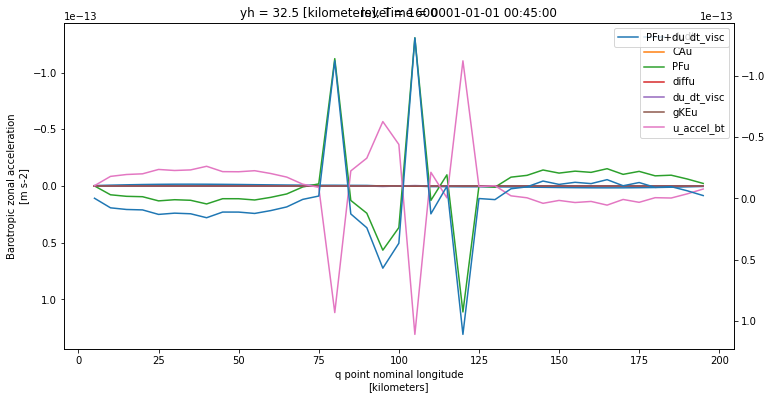

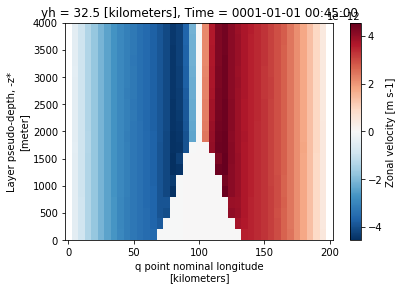

In [56]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 2
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))
plt.show()
prog.u.isel(yh = 0, Time = time).plot()

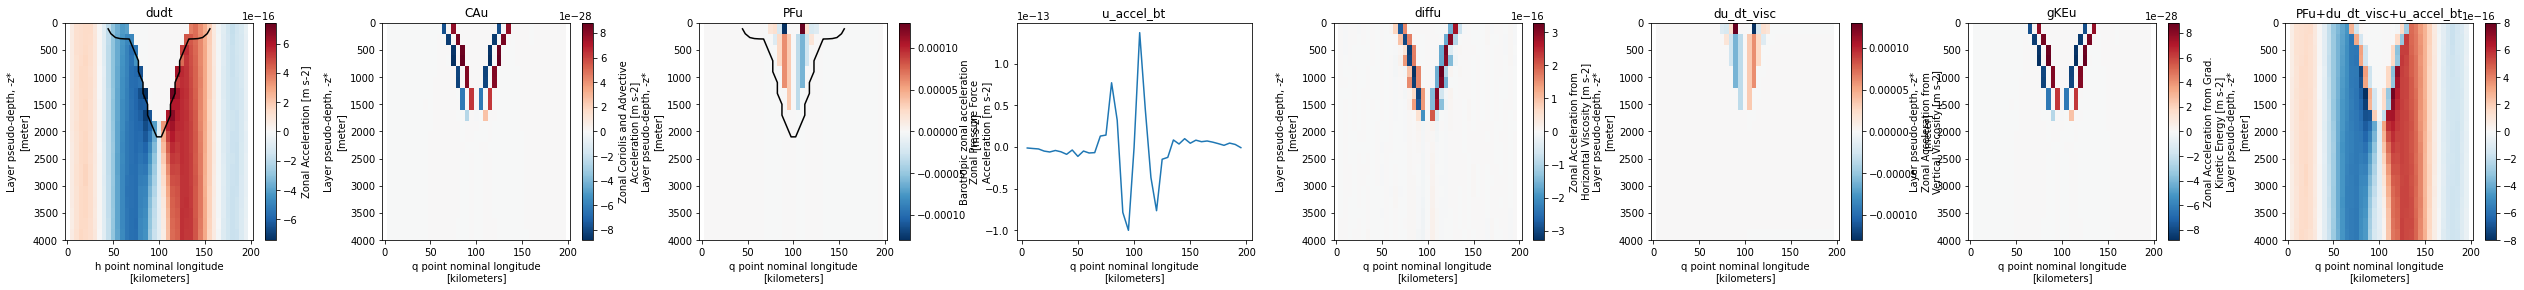

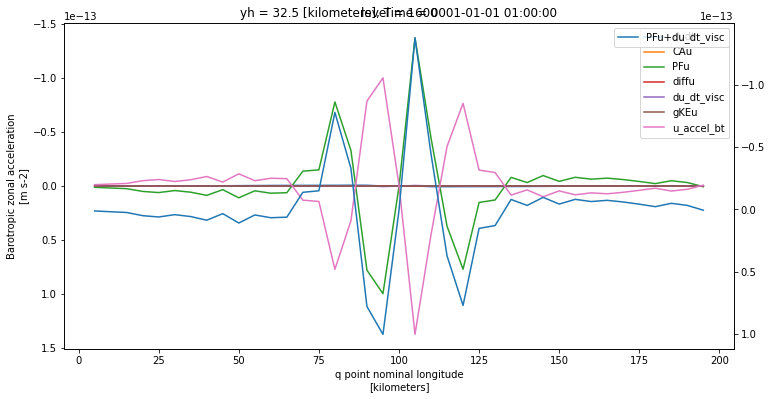

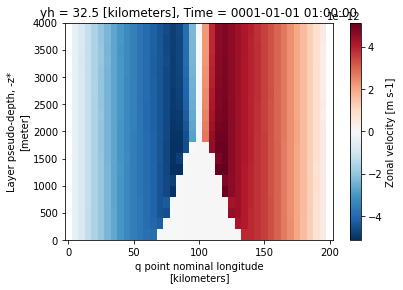

In [57]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 3
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))

plt.show()
prog.u.isel(yh = 0, Time = time).plot()

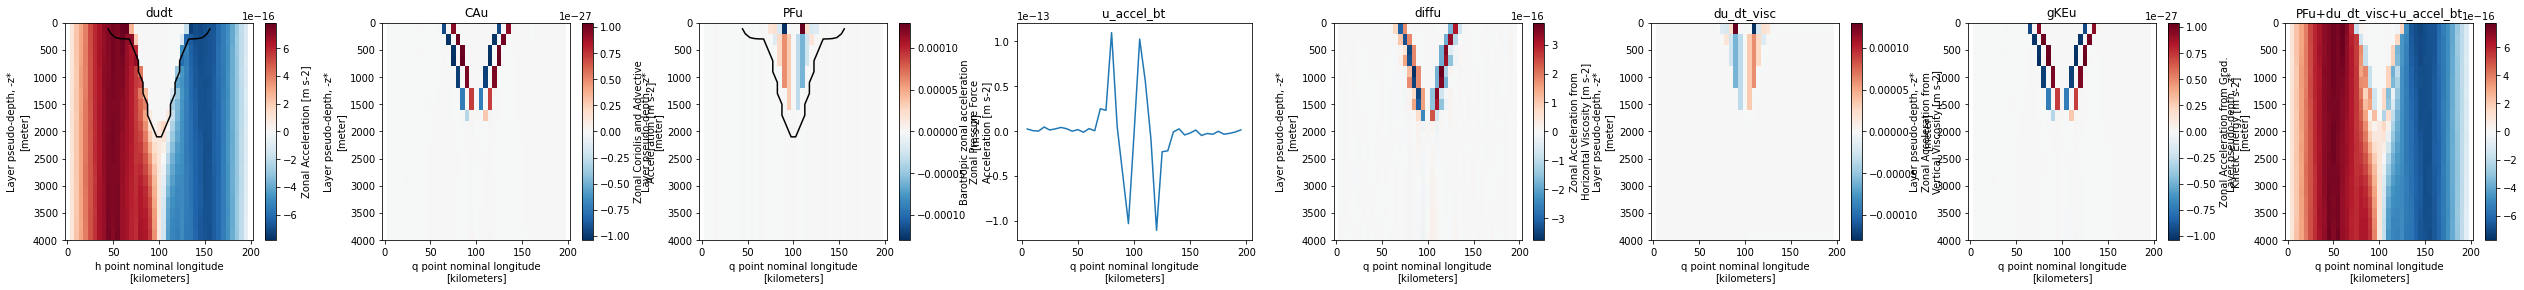

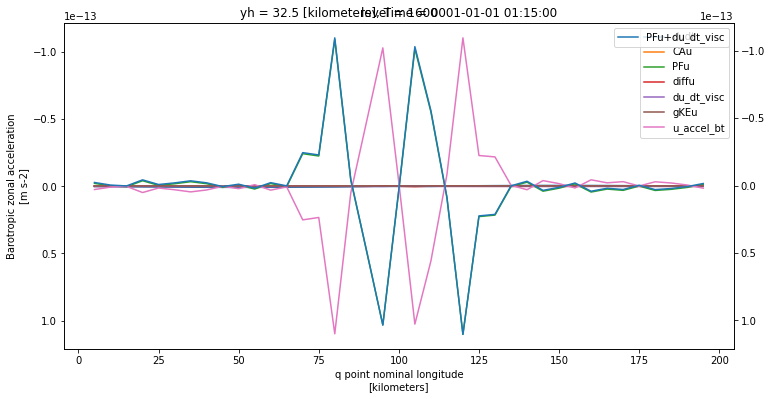

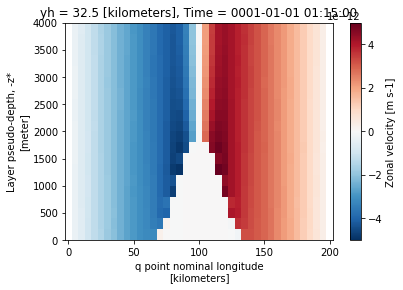

In [58]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 4
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))

plt.show()
prog.u.isel(yh = 0, Time = time).plot()

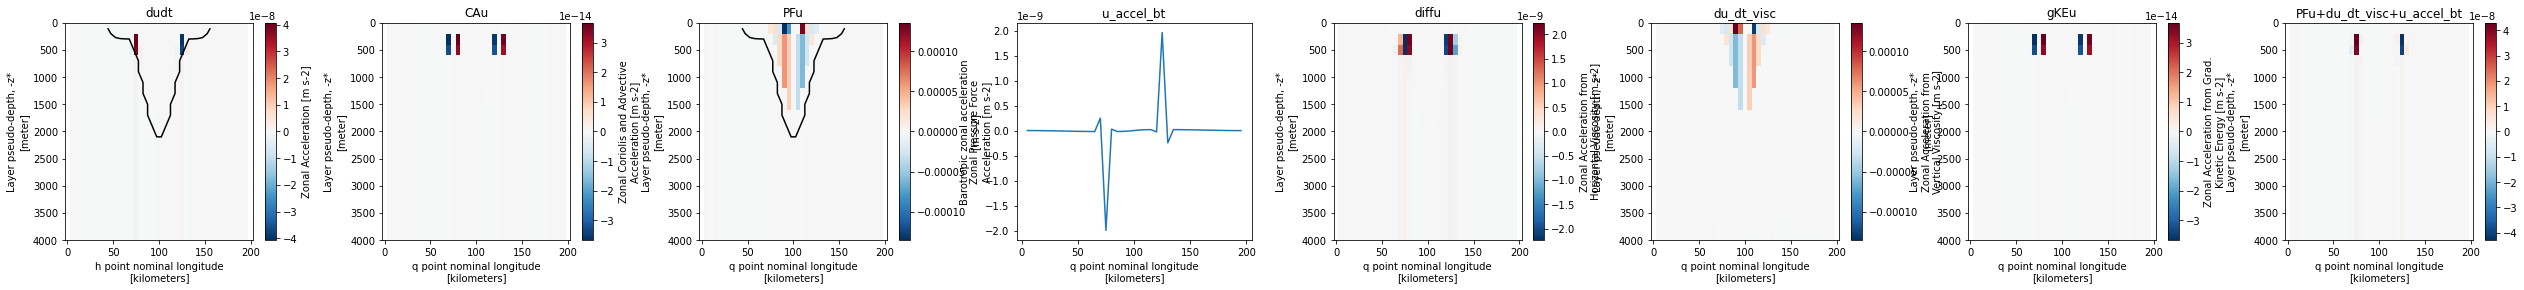

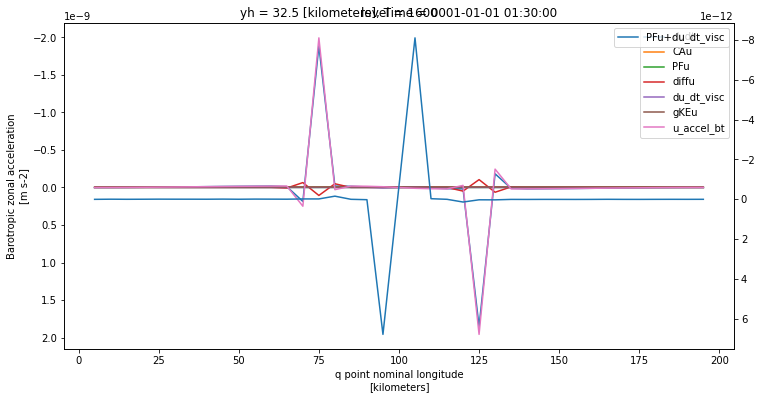

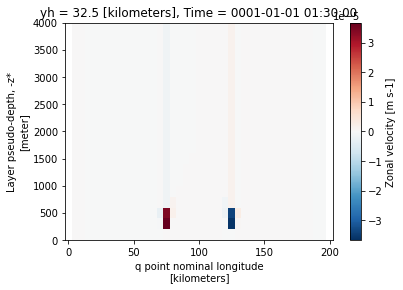

In [59]:
label = 'zstar-minthick1e-12-intxpa'
mom = open_mom(label)
prog = open_files(label)
time = 5
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))

plt.show()
prog.u.isel(yh = 0, Time = time).plot()

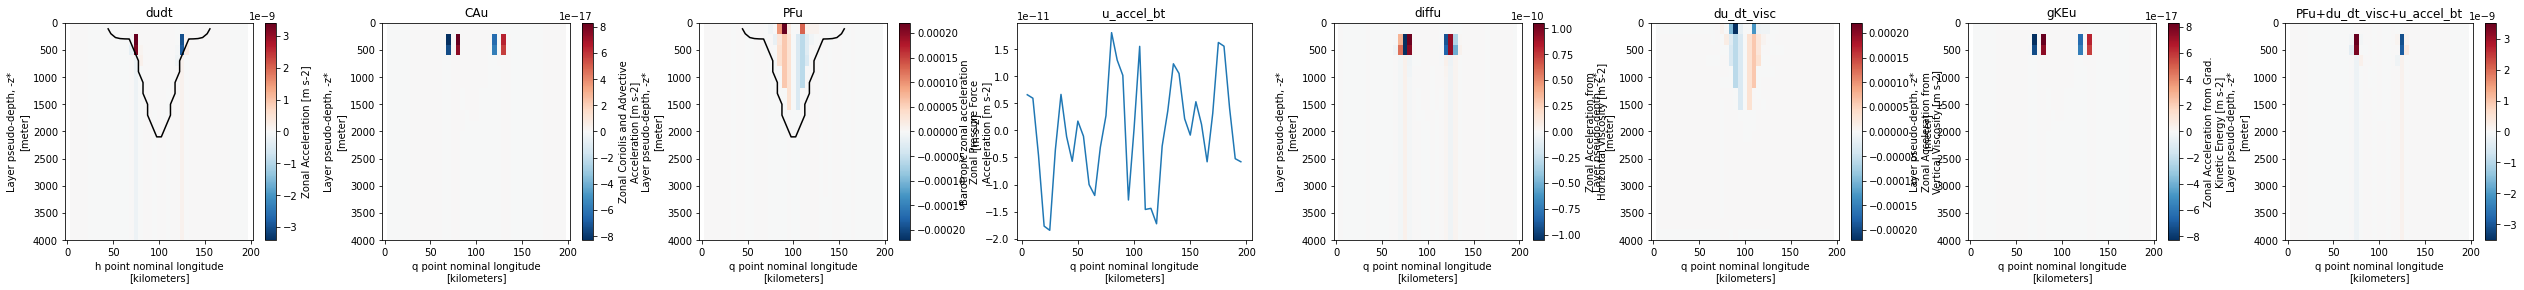

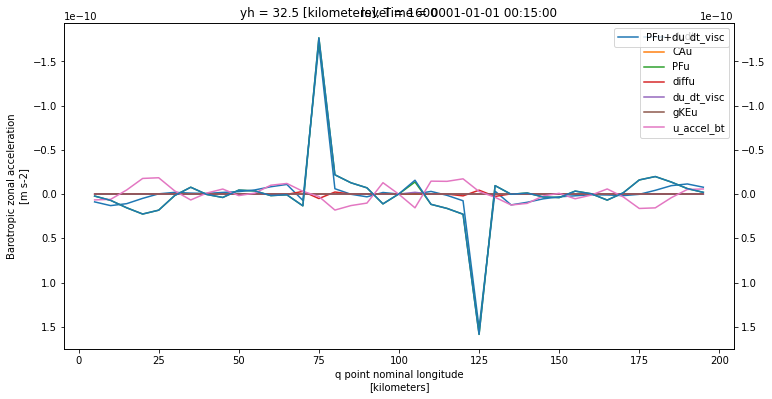

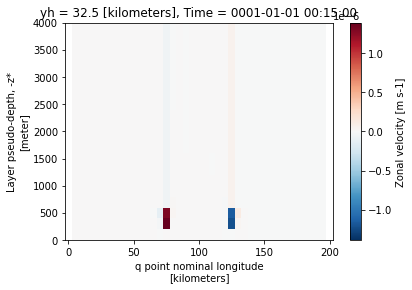

In [60]:
label = 'zstar-minthick1e-12-intxpa-dt100'
mom = open_mom(label)
prog = open_files(label)
time = 0
y = 0

fig, axes = plt.subplots(ncols = 8, figsize= (44,4))
mom.dudt.isel(Time = time, yh = y).plot(ax = axes[0], yincrease = False)#, vmin = -1e-12, vmax = 1e-12, cmap = 'RdBu_r')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[0], yincrease = False, levels = [199], colors = 'k')
prog.h.isel(Time = time, yh = y).plot.contour(ax = axes[2], yincrease = False, levels = [199], colors = 'k')
axes[0].set_title('dudt')

mom.CAu.isel(Time = time, yh = y).plot(ax = axes[1], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[1].set_title('CAu')
mom.PFu.isel(Time = time, yh = y).plot(ax = axes[2], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[2].set_title('PFu')
mom.u_accel_bt.isel(Time = time, yh = y).plot(ax = axes[3])
axes[3].set_title('u_accel_bt')
mom.diffu.isel(Time = time, yh = y).plot(ax = axes[4], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[4].set_title('diffu')
mom.du_dt_visc.isel(Time = time, yh = y).plot(ax = axes[5], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[5].set_title('du_dt_visc')
mom.gKEu.isel(Time = time, yh = y).plot(ax = axes[6], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[6].set_title('gKEu')
(mom.du_dt_visc+mom.PFu+mom.u_accel_bt).isel(Time = time, yh = y).plot(ax = axes[7], yincrease = False)#, cmap = 'RdBu_r', vmin = -1e-12, vmax = 1e-12)
axes[7].set_title('PFu+du_dt_visc+u_accel_bt')


fig.subplots_adjust(wspace = 0.35)
plt.show()

depth = 1600
fig, ax = plt.subplots(figsize = (12,6))
for term in ['dudt','CAu','PFu','diffu','du_dt_visc','gKEu']:
    mom[term].isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(yincrease = False, label = term)
term = 'u_accel_bt'
mom[term].isel(Time = time, yh = y).plot(yincrease = False, label = term)
plt.legend()
ax2 = ax.twinx()
(mom['du_dt_visc']+mom['PFu']).isel(Time = time, yh = y).sel(zl = depth, method = 'nearest').plot(ax = ax2,yincrease = False, label = 'PFu+du_dt_visc')
plt.legend()
plt.title('level = '+str(depth))

plt.show()
prog.u.isel(yh = 0, Time = time).plot()

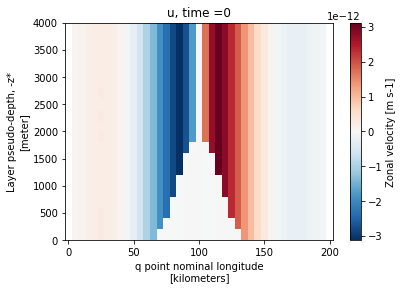

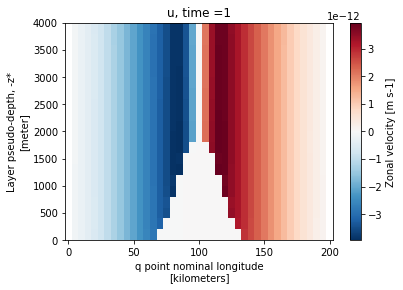

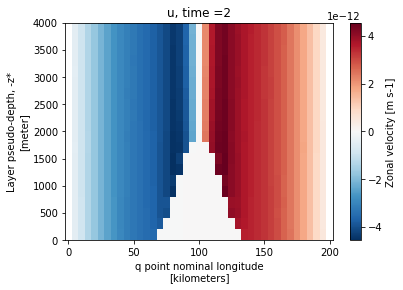

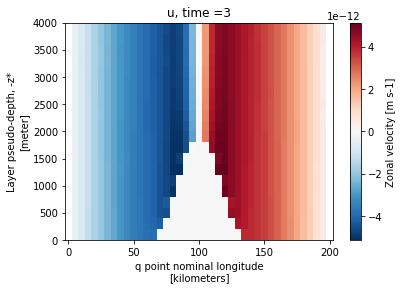

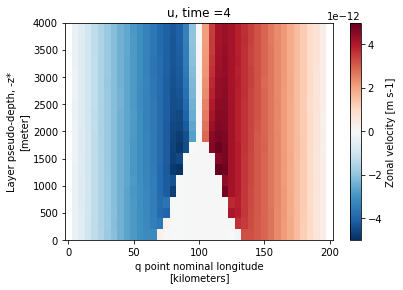

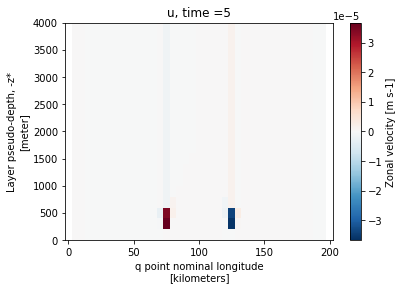

In [87]:
for time in np.arange(6):
    
    prog.u.isel(yh = 0, Time = time).plot()
    plt.title('u, time ='+str(time))
    plt.show()